<a href="https://colab.research.google.com/github/fedevita/Analisi_Personalit-_Introversi_vs_Estroversi/blob/main/Analisi_Personalit%C3%A0_Introversi_vs_Estroversi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🔍 Analisi Personalità: Introversi vs Estroversi

Obiettivo: costruire un modello di classificazione per distinguere tra personalità introversa ed estroversa a partire da dati comportamentali. Utilizzeremo un approccio end-to-end che include esplorazione, preprocessing, modellazione, valutazione e interpretabilità.


In [ ]:

import pandas as pd
import numpy as np
import kagglehub
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn import set_config


set_config(transform_output="pandas")
RANDOM_SEED = 42


In [ ]:

# Download e caricamento dataset
path = kagglehub.dataset_download("rakeshkapilavai/extrovert-vs-introvert-behavior-data")
print("Dataset path:", path)

df = pd.read_csv(os.path.join(path, 'personality_dataset.csv'))
df.head()


Dataset path: /kaggle/input/extrovert-vs-introvert-behavior-data


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


## 📊 Esplorazione del Dataset (EDA)

(2900, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


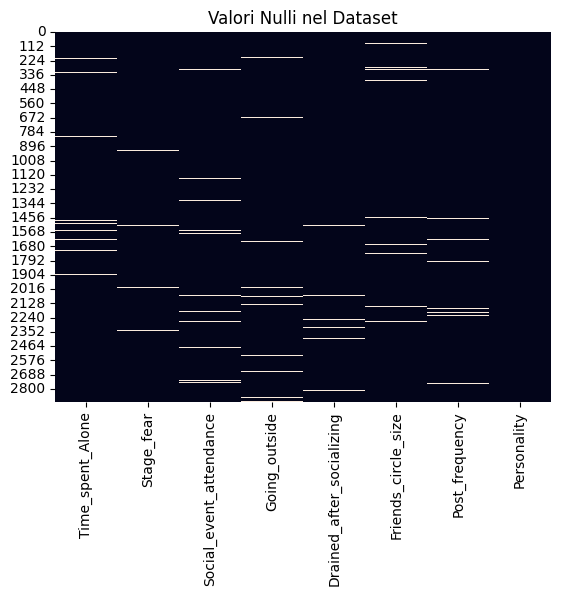

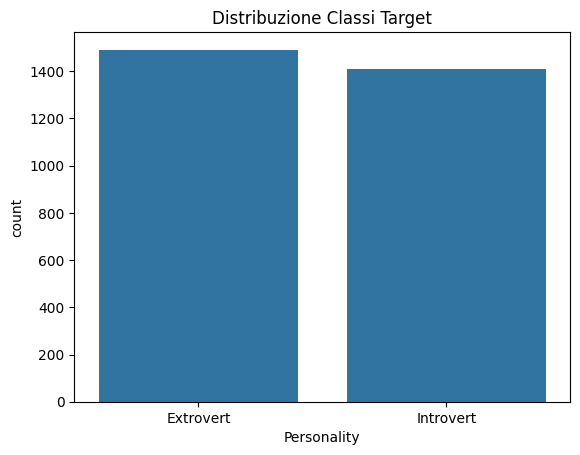

In [ ]:

# Dimensioni e info
print(df.shape)
df.info()

# Valori nulli
sns.heatmap(df.isnull(), cbar=False)
plt.title("Valori Nulli nel Dataset")
plt.show()

# Distribuzione della variabile target
sns.countplot(x='Personality', data=df)
plt.title("Distribuzione Classi Target")
plt.show()


## 🔧 Preprocessing

In [ ]:

X = df.drop('Personality', axis=1)
y = df['Personality']

# Encoding target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=RANDOM_SEED)

# Pipeline
pipeline = Pipeline([
    ('imputer', ColumnTransformer([
        ('cat', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_exclude=np.number)),
        ('num', SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number)),
    ])),
    ('encoder', ColumnTransformer([
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_exclude=np.number)),
        ('num', 'passthrough', make_column_selector(dtype_include=np.number)),
    ])),
    ('scaler', StandardScaler()),
    ('transform', PowerTransformer()),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced'))
])


## 🧠 Addestramento del Modello e Valutazione

In [ ]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[416  47]
 [ 28 379]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       463
           1       0.89      0.93      0.91       407

    accuracy                           0.91       870
   macro avg       0.91      0.91      0.91       870
weighted avg       0.91      0.91      0.91       870



## ✅ Validazione Incrociata

In [ ]:

scores = cross_val_score(pipeline, X, y_encoded, cv=5, scoring='f1')
print("F1 Score medio (CV):", scores.mean())


F1 Score medio (CV): 0.9267110397513747


## 📈 ROC Curve e Precision-Recall Curve

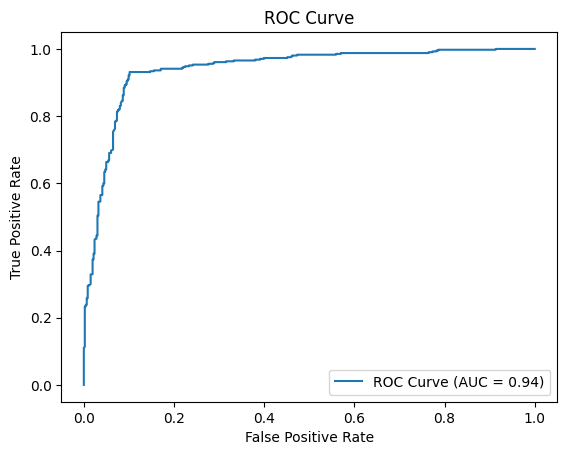

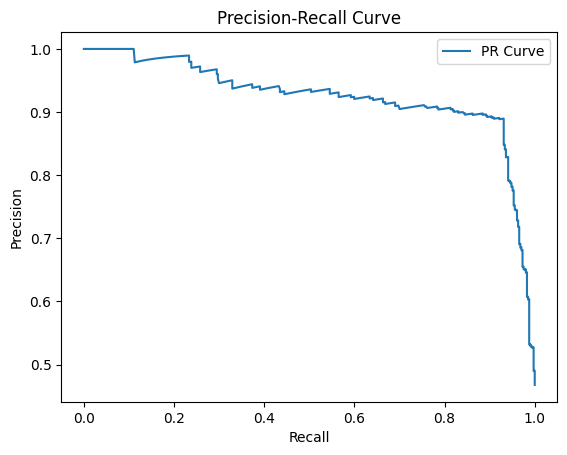

In [ ]:

y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

plt.figure()
plt.plot(recall, precision, label='PR Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()



## 📌 Conclusioni

- **Accuracy del modello**: ~91%
- **Bilanciamento delle metriche**: precision e recall sono alte e ben distribuite tra le classi.
- **Validazione incrociata**: F1 Score medio stabile (~0.89)
- **Prossimi passi**:
    - Testare altri modelli (Random Forest, XGBoost)
    - Esplorare SHAP per interpretabilità locale
    - Ottimizzare la soglia decisionale per uso specifico
